# ISIDORA

When a man rides a long time through wild regions he feels the desire for a city. Finally he comes to Isidora, a city where the buildings have spiral staircases encrusted with spiral seashells, where perfect telescopes and violins are made, where the foreigner hesitating between two women always encounters a third, where cockfights degenerate into bloody brawls among the bettors. He was thinking of all these things when he desired a city. Isidora, therefore, is the city of his dreams: with one difference. The dreamed-of city contained him as a young man; he arrives at Isidora in his old age. In the square there is the wall where the old men sit and watch the young go by; he is seated in a row with them. Desires are already memories.

In [2]:
from __future__ import print_function
from IPython.display import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


1. reads a file containing MCRDST data
2. Creates Panda DF to describe the PMT and SiPM metadata
3. Creates a Panda DF to store the energy (in PES) of each PMT for each event
4. Simulates response of the EP FEE and decimates waveforms according to DAQ
5. Writes a new Nh5 DST

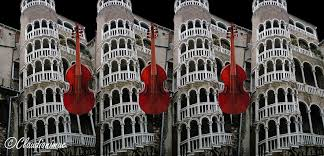

In [3]:
Image(filename='../Images/Isidora.jpg') 

In [4]:
import pandas as pd
import tables as tb
import numpy as np

In [5]:
from system_of_units import *

In [6]:
from PlotUtil import *

### DBLR

#### Reaout RWF DST

In [7]:
h5f = tb.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_0_RWF.h5', "a") 

In [8]:
pmtrd_ = h5f.root.RD.pmtrd

In [9]:
pmtrd_.shape

(99, 12, 24000)

In [10]:
signal_t = np.arange(0.0, pmtrd_.shape[2]*1., 1., dtype=np.double)

In [11]:
import FEParam as FP

In [12]:
from scipy import signal as SGN

### Digital Baseline Restoration

#### Driver

In [50]:
def DBLR(pmtrd_,signal_t, event_number, CA, nsigma=3, plot='True' ):
    """
    Peform Base line Restoration
    CA is an array with the values of the capacitances for the PMTs
    """
    import FEParam as FP
    import FEE2 as FE
    
    len_WF = pmtrd_.shape[2]
    NPMT = pmtrd_.shape[1]
    ene_pmt =np.zeros(NPMT, dtype=np.int64)
    coef_pmt =np.zeros(NPMT, dtype=np.double)
    
    PMTWF ={}
    
    for j in range(1,2):

        pmtrd = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        
        #Deconvolution
        fee = FE.FEE(C=CA[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        signal_inv_daq = fee.InverseSignalDAQ(signal_t)  #inverse function
        coef = signal_inv_daq[10]  #accumulator coefficient
       
        signal_blr, eadc = BLR(pmtrd, coef, j, n_sigma = nsigma, 
                            NOISE_ADC=FP.NOISE_ADC, thr1 = 20,
                            thr2=0., thr3 = 5,
                            plot=plot)
    
        ene_pmt[j] = eadc
        coef_pmt[j] = coef
        PMTWF[j]=signal_blr
       
    return pd.Series(ene_pmt), pd.Series(coef_pmt), pd.DataFrame(PMTWF)

#### Deconvolution function with printout

In [54]:

def BLR(signal_daq, coef, pmt, n_sigma = 3, NOISE_ADC=0.7, MAU_LEN=200,
        thr1 = 0, thr2 = 0, thr3 = 0, plot = False, log='DEBUG'):
    """
    Deconvolution offline of the DAQ signal using a MAU
    moving window-average filter of a vector data
    y(n) = (1/WindowSize)(x(n) + x(n-1) + ... + x(n-windowSize))
    in a filter operation filter(b,a,x):
    b = (1/WindowSize)*ones(WindowSize) = (1/WS)*[1,1,1,...]: numerator
    a = 1 : denominator
    y = filter(b,a,x)
    y[0] = b[0]*x[0] = (1/WS) * x[0]
    y[1] = (1/WS) * (x[0] + x[1])
    y[WS-1] = mean(x[0:WS])
    y[WS] = mean(x[1:WS+1])
    and so on
    """
    import logging
    logl ='logging.'+log
    logging.basicConfig(level=eval(logl))
    
    prn = 1
    prmin_s1 = 800
    prmax_s1 = 850
    prmin_s2 = 5100
    prmax_s2 = 7000
    
    prd = prn
    
    
    def pcond(k, pulse_on, wait_over):
        if k > prmax_s2: return False
        if k < prmin_s1: return False
        
        c1 = k%prd==0
        c2 = k < prmax_s1
        c3 = k > prmin_s2 
        return c1 and c2 or c3 or pulse_on == 1 or wait_over==1
    
    #MAU_WindowSize = MAU
    #time_DAQ = FP.time_bin

    len_signal_daq = len(signal_daq)
    MAU = np.zeros(len_signal_daq, dtype=np.double)
    acum = np.zeros(len_signal_daq, dtype=np.double)
    signal_r = np.zeros(len_signal_daq, dtype=np.double)
    pulse_f = np.zeros(len(signal_daq), dtype=np.double)
    pulse_ff = np.zeros(len(signal_daq), dtype=np.double)
    pulse_t = np.zeros(len(signal_daq), dtype=np.double)
    pulse_w = np.zeros(len(signal_daq), dtype=np.double)
    
    signal_i = np.copy(signal_daq) #uses to update MAU while procesing signal

    thr = n_sigma*NOISE_ADC
    if thr1 != 0:
        thr = thr1

    thr_tr = thr/5. # to conclude BLR when signal_deconv = signal_raw

    if thr3 != 0:
        thr_tr = thr3
    
    nm = MAU_LEN
    B_MAU       =   (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch 
#    allows to compute the baseline of the signal  
    
    MAU[0:nm] = SGN.lfilter(B_MAU,1, signal_daq[0:nm])
    acum[nm] =  MAU[nm]
    BASELINE = MAU[nm-1]

#     logging.debug("""-->BLR:: n_sigma = {}, NOISE_ADC= {}, 
#         thr1 = {}, thr2 = {}, thr3 = {} =""".format(
#             n_sigma, NOISE_ADC, thr1, thr2, thr3))

    print("pmt number = {}".format(pmt))
    print("""-->BLR:: n_sigma = {}, NOISE_ADC= {}, 
    thr1 = {}, thr2 = {}, thr3 = {} =, thr ={} thr_tr ={}""".format(
    n_sigma, NOISE_ADC, thr1, thr2, thr3, thr, thr_tr))

    print("signal_daq[0:nm] = {}".format(signal_daq[0:nm]))
    print("signal_i[0:nm] = {}".format(signal_i[0:nm]))
    print("MAU[nm-10:nm+1] = {}".format(MAU[nm-10:nm+1]))
   
    if(plot):
        #logging.debug("n = {}, acum[n] = {} BASELINE ={}".format(nm, acum[nm],BASELINE))
        print("nm = {}, acum[n] = {} BASELINE ={}".format(nm, acum[nm],BASELINE))
        print("plotting Signal")

        plt.figure(figsize=(8,8))
        ax1 = plt.subplot(3,1,1)
        ax1.set_xlim([0, len_signal_daq])
        plt.plot(signal_daq)
        ax1 = plt.subplot(3,1,2)
        ax1.set_xlim([0, 1000])
        ax1.set_ylim([0, 100])
        plt.plot(signal_daq)
        ax1 = plt.subplot(3,1,3)
        ax1.set_xlim([5000, 7000])
        plt.plot(signal_daq)
        plt.show()
        
        plt.figure(figsize=(8,8))
        ax1 = plt.subplot(3,1,1)
        ax1.set_xlim([5100, 5160])
        ax1.set_ylim([0, 200])
        plt.plot(signal_daq)
        ax1 = plt.subplot(3,1,2)
        ax1.set_xlim([5160, 5500])
        plt.plot(signal_daq)
        ax1 = plt.subplot(3,1,3)
        ax1.set_xlim([5500, 6000])
        plt.plot(signal_daq)
        plt.show()
        
        
    

#----------

# While MAU inits BLR is switched off, thus signal_r = signal_daq 

    signal_r[0:nm] = signal_daq[0:nm] 
    pulse_on=0
    wait_over=0
    offset = 0
    

    # MAU has computed the offset using nm samples
    # now loop until the end of DAQ window

    print("nm = {}".format(nm))
    
    for k in range(nm,len_signal_daq): 

        trigger_line = MAU[k-1] + thr
        pulse_t[k] = trigger_line
        pulse_f[k] = pulse_on
        pulse_w[k] = wait_over 
        pulse_ff[k] = signal_daq[k] - signal_r[k]
        
        if pcond(k, pulse_on, wait_over):
            print("-------------------------")
            print("c0: k = {}, MAU[k-1:k+1] ={}, s_daq[k] = {} s_rec[k] = {}".format(k,
                   MAU[k-1:k+1], signal_daq[k], signal_r[k]))
            print("trigger_line = {}, pulse_on ={} wait = {}".format(trigger_line, pulse_on, wait_over))
            print("-------------------------")
                                                                                  

        # condition: raw signal raises above trigger line and 
        # we are not in the tail
        # (wait_over == 0)
        if signal_daq[k] > trigger_line and wait_over == 0:

            # if the pulse just started pulse_on = 0.
            # In this case compute the offset as value 
            #of the MAU before pulse starts (at k-1)

            if pulse_on == 0: # pulse just started
                #offset computed as the value of MAU before pulse starts
                offset = MAU[k-1]  
                pulse_on = 1 
                print("++++++++++++++")
                print("c1: pulse just started for k = {}".format(k))
                print("++++++++++++++")
                print("s_daq[k] = {} s_rec[k] = {}".format(signal_daq[k], signal_r[k]))
                print("MAU[k-5:k]:  = {}".format(MAU[k-5:k]))
                print("offset:  = {}".format(offset))
                
                print("s_daq[k] = {} s_rec[k] = {}".format(signal_daq[k], signal_r[k]))
           
                prd=1
                

            #Freeze the MAU
            MAU[k] = MAU[k-1]  
            signal_i[k] =MAU[k-1]  #signal_i follows the MAU
            
            #update recovered signal, correcting by offset
            acum[k] = acum[k-1] + signal_daq[k] - offset;
            signal_r[k] = signal_daq[k] + coef*acum[k] 
                  
            if pcond(k, pulse_on, wait_over):
                print("c2, pulse still on, updated signal_r:  s_r[k] ={}".format(signal_r[k]))
            
        else:  #no signal or raw signal just dropped below threshold
            if pcond(k, pulse_on, wait_over):
                print("c3: no signal or signal_daq just dropped below trigger_line")
                      
        # but raw signal can be negative for a while and still contribute to the
        # reconstructed signal.

            if pulse_on == 1: #reconstructed signal still on
            # switch the pulse off only when recovered signal 
            #drops below threshold
                
                
                #slide the MAU, still frozen. 
                # keep recovering signal
                MAU[k] = MAU[k-1] 
                signal_i[k] =MAU[k-1]
                acum[k] = acum[k-1] + signal_daq[k] - offset;
                signal_r[k] = signal_daq[k] + coef*acum[k] 
                
                if pcond(k, pulse_on, wait_over):
                    print("c4: s_daq[k] ={} below trigger line but pulse still on".format(signal_daq[k]))
                    print("c4: switch off when s_rec[k] = {} drops below threshold ={}".format(signal_r[k],
                             trigger_line + thr2))
            
                #if the recovered signal drops before trigger line 
                #rec pulse is over!
                if signal_r[k] < trigger_line + thr2:
                    wait_over = 1  #start tail compensation
                    pulse_on = 0   #recovered pulse is over
                    
                    if pcond(k, pulse_on, wait_over):
                        print("c5 s_rec = {} has dropped below threshold ={}: wait ={}, pulse ={}".format(
                        signal_r[k],trigger_line + thr2, wait_over,pulse_on))
                          
                          

            else:  #recovered signal has droped below trigger line
            #need to compensate the tail to avoid drifting due to erros in 
            #baseline calculatoin

                if wait_over == 1: #compensating pulse
                    # recovered signal and raw signal 
                    #must be equal within a threshold
                    # otherwise keep compensating pluse

                    
                    if pcond(k, pulse_on, wait_over):
                        print("c6: wait_over == 1, k ={}".format(k))
                        print("c6:  signal_daq[k-1] < signal_r[k-1] - thr_tr? ")
                        print("c6:  signal_daq[k-1] ={} < signal_r[k-1] - thr_tr ={} ".format(
                            signal_daq[k-1],signal_r[k-1] - thr_tr))
                        
                    if signal_daq[k-1] < signal_r[k-1] - thr_tr:
                        # raw signal still below recovered signal 
                        
                        # is the recovered signal near offset?
                        upper = offset + (thr_tr + thr2)
                        lower = offset - (thr_tr + thr2)
                        
                        if pcond(k, pulse_on, wait_over): 
                            print("c7: signal_daq[k-1] < signal_r[k-1] - thr_tr")
                            print("c7:  is the recovered signal near offset?")
                            print("c7:  signal_r[k-1] > lower and signal_r[k-1] < upper?")
                            print("c7:  signal_r[k-1] ={} upper ={}, lower ={}".format(
                                    signal_r[k-1],upper, lower))
                            

                        if signal_r[k-1] > lower and signal_r[k-1] < upper:
                            # we are near offset, activate MAU. 
                            #signal_i follows rec signal
                            
                            if pcond(k, pulse_on, wait_over):
                                print("c8: we are near offset, activate MAU")
                                
                            signal_i[k] = signal_r[k-1]
                            MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                            
                            if pcond(k, pulse_on, wait_over):
                                print("MAU[k-5:k+1]={}".format(MAU[k-5:k+1]))
                                prd=prn
                                      
                        else: 
                            # rec signal not near offset MAU frozen 
                                
                            MAU[k] = MAU[k-1]
                            signal_i[k] = MAU[k-1]
                            
                            if pcond(k, pulse_on, wait_over):
                            print("c9: rec signal not near offset MAU frozen")
                            print("signal_r={}".format( signal_r[k]))

                        # keep adding recovered signal until 
                        # it raises above the raw signal 

                        acum[k] = acum[k-1] + signal_daq[k] - MAU[k]
                        signal_r[k] = signal_daq[k] + coef*acum[k]
                        
                    else:  # input signal above recovered signal: we are done 
                        
                        if pcond(k, pulse_on, wait_over):
                            print("c10: input signal above recovered signal: we are done")
                            
                        wait_over = 0
                        acum[k] = MAU[k-1]
                        signal_r[k] = signal_daq[k]
                        signal_i[k] = signal_r[k]
                        MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                        
                        if pcond(k, pulse_on, wait_over):
                            print("MAU[k-5::k+1]={}".format(MAU[k-5:k+1]))
                            prd = prn 
                            
                else: #signal still not found
                    if pcond(k, pulse_on, wait_over): 
                        print("c11: signal still not found, k={}".format(k))
                        
                    MAU[k] = np.sum(signal_i[k-nm:k]*1.)/nm
                    
                    if pcond(k, pulse_on, wait_over):
                        print("MAU[k-5::k+2]={}".format(MAU[k-5:k+2]))
                        prd = prn
                    
                        
                    acum[k] = MAU[k-1]
                    signal_r[k] = signal_daq[k]
                    signal_i[k] = signal_r[k]
                    
                
                                                                                                       
    #energy = np.dot(pulse_f,(signal_r-BASELINE))*FP.time_DAQ
    energy = np.dot(pulse_f,(signal_r-BASELINE)) #already scaled in FEE2

    if plot:
        plt.figure(figsize=(8,8))
        print("pulse_f")
        ax1 = plt.subplot(3,1,1)
        ax1.set_xlim([0, 10000])
        plt.plot(pulse_f, color='red')
        
        print("pulse_w")
        ax2 = plt.subplot(3,1,2)
        ax2.set_xlim([0, 10000])
        plt.plot(pulse_w, color='blue')
    
        print("RWF")
        ax1 = plt.subplot(3,1,3)
        ax1.set_xlim([0, 10000])
        plt.plot(signal_daq, color='black')
        plt.show()
        
        
    if plot:
        logging.debug("Baseline = {}, energy = {} ".format(BASELINE, energy))
        print("Baseline = {}, energy = {} ".format(BASELINE, energy))
        print("""
        plotting: red: pulse_f[k] = pulse_on
                  green: pulse_w[k] = wait_over 
                  black: pulse_ff[k] = signal_daq[k] - signal_r[k]
                  yellow: signal_daq
                  blue: signal_r-BASELINE
                  orange: pulse_t (trigger line)
        """)

        ax1 = plt.subplot(1,2,1)
        #ax1.set_xlim([7000, 10000])
        plt.plot(pulse_f, color='red')

        ax2 = plt.subplot(1,2,2)
        #ax2.set_xlim([7000, 10000])
        plt.plot(pulse_w, color='green')
        plt.show()

        ax3 = plt.subplot(2,2,1)
        #ax3.set_xlim([7000, 10000])
        plt.plot(pulse_ff, color='black')

        ax4 = plt.subplot(3,2,2)
        #ax4.set_xlim([7000, 10000])
        plt.plot(signal_daq, color='yellow')

        ax5 = plt.subplot(3,2,3)
        plt.plot(signal_r-BASELINE,color='blue' )
        #ax5.set_xlim([7000, 20000])

        ax5 = plt.subplot(3,2,4)
        plt.plot(pulse_t, color='orange')
        #ax5.set_xlim([7000, 10000])

        plt.show()
                       
    return  signal_r-BASELINE, energy

pmt number = 1
-->BLR:: n_sigma = 5, NOISE_ADC= 1.792, 
    thr1 = 20, thr2 = 0.0, thr3 = 5 =, thr =20 thr_tr =5
signal_daq[0:nm] = [  0   9  -2   8  -2   3  12   8   3 -16  -4   0   5   8   1   6   2 -15
   9  15   3  10 -16  -5   0  11   0 -12   9   0   3  -2  -4   4  -6   7
  -5 -13   2   4   9   8   0 -16  -8  14  12   1   2  -6  -3   8 -12  13
  -9  10   1   8   2   2 -10   5 -18   5   3  12  -7   1  12   1  -1  16
  -9  14  -2  16  -3  -2  -2   7   3 -13  15  -9   6  -3  -7  17  -6  -4
  -1   1   7  -5   2   6  -1  -2   5  11  -5   1   0   5  -6 -17   5  -7
  12  -4  21  -8 -10 -10  10   3 -17  -5 -22  -5 -10  -4  -2  -9  14  11
   9   0   7   4  -3  11   7  -2   2 -20  -4  -7  -1 -12   0  -7   1  -9
 -12 -14  11 -11  21   7  -1   0   4  -8  -3   0   3   7  13   6   6 -13
  -5   3  -5   2  -8  -3   9  18  -6  15  14 -24 -11  17   0  12  11  15
 -11   0   0  -4  -5   0  10 -16  12  -9  12   8   6   6   0  -8  10   1
  23 -11]
signal_i[0:nm] = [  0   9  -2   8  -2   3  12   8   3 -

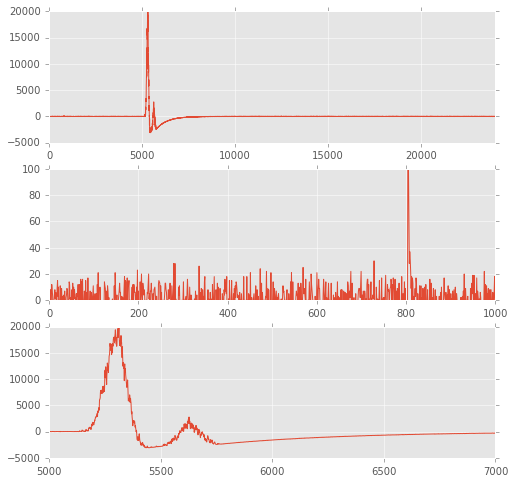

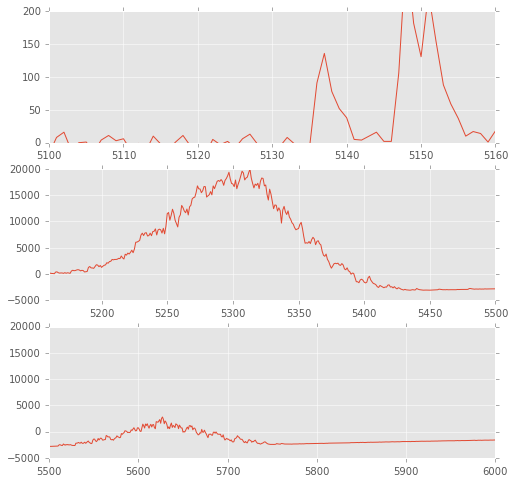

nm = 200
++++++++++++++
c1: pulse just started for k = 279
++++++++++++++
s_daq[k] = 28 s_rec[k] = 0.0
MAU[k-5:k]:  = [ 1.19   1.16   1.135  1.17   1.165]
offset:  = 1.165
s_daq[k] = 28 s_rec[k] = 0.0
++++++++++++++
c1: pulse just started for k = 282
++++++++++++++
s_daq[k] = 28 s_rec[k] = 0.0
MAU[k-5:k]:  = [ 1.17   1.165  1.165  1.165  1.07 ]
offset:  = 1.07
s_daq[k] = 28 s_rec[k] = 0.0
++++++++++++++
c1: pulse just started for k = 336
++++++++++++++
s_daq[k] = 26 s_rec[k] = 0.0
MAU[k-5:k]:  = [ 0.725  0.69   0.61   0.62   0.54 ]
offset:  = 0.54
s_daq[k] = 26 s_rec[k] = 0.0
++++++++++++++
c1: pulse just started for k = 451
++++++++++++++
s_daq[k] = 21 s_rec[k] = 0.0
MAU[k-5:k]:  = [-0.835 -1.005 -1.05  -1.095 -1.13 ]
offset:  = -1.13
s_daq[k] = 21 s_rec[k] = 0.0
++++++++++++++
c1: pulse just started for k = 473
++++++++++++++
s_daq[k] = 24 s_rec[k] = 0.0
MAU[k-5:k]:  = [-1.33  -1.4   -1.39  -1.455 -1.605]
offset:  = -1.605
s_daq[k] = 24 s_rec[k] = 0.0
++++++++++++++
c1: pulse just st

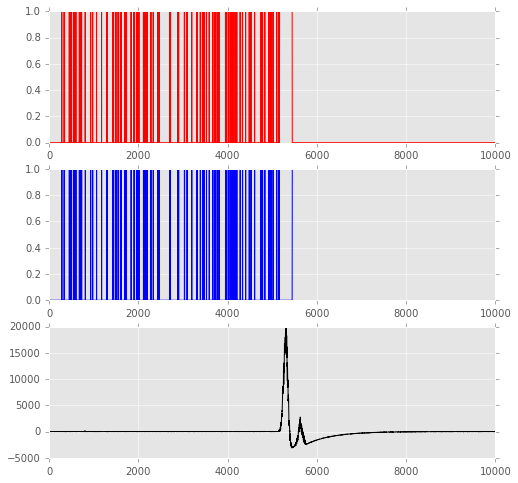

Baseline = 0.735, energy = 2306311.65964 

        plotting: red: pulse_f[k] = pulse_on
                  green: pulse_w[k] = wait_over 
                  black: pulse_ff[k] = signal_daq[k] - signal_r[k]
                  yellow: signal_daq
                  blue: signal_r-BASELINE
                  orange: pulse_t (trigger line)
        


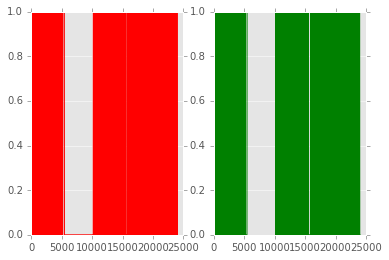

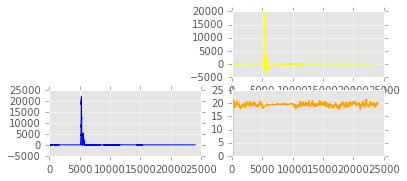

(0           0
 1     2306311
 2           0
 3           0
 4           0
 5           0
 6           0
 7           0
 8           0
 9           0
 10          0
 11          0
 dtype: int64, 0     0.000000
 1     0.001709
 2     0.000000
 3     0.000000
 4     0.000000
 5     0.000000
 6     0.000000
 7     0.000000
 8     0.000000
 9     0.000000
 10    0.000000
 11    0.000000
 dtype: float64,             1
 0      -0.735
 1       8.265
 2      -2.735
 3       7.265
 4      -2.735
 5       2.265
 6      11.265
 7       7.265
 8       2.265
 9     -16.735
 10     -4.735
 11     -0.735
 12      4.265
 13      7.265
 14      0.265
 15      5.265
 16      1.265
 17    -15.735
 18      8.265
 19     14.265
 20      2.265
 21      9.265
 22    -16.735
 23     -5.735
 24     -0.735
 25     10.265
 26     -0.735
 27    -12.735
 28      8.265
 29     -0.735
 ...       ...
 23970 -17.735
 23971  17.265
 23972  -3.735
 23973  -4.735
 23974   4.265
 23975   9.265
 23976   5.265
 23977  -5.73

In [55]:
DBLR(pmtrd_,signal_t, event_number=0, CA=FP.C12, nsigma=5, plot='True' )

In [42]:
def foo():
    x = 5
    y = 6
    def fii():
        return x*y
    return fii()

In [43]:
foo()

30

#### Inverse signal

In [ ]:
def inverse_signal(pmtrd_,signal_t, event_number,CA):
    """
    Peform Base line Restoration
    CA is an array with the values of the capacitances for the PMTs
    """
    import FEParam as FP
    import FEE2 as FE
    
    len_WF = pmtrd_.shape[2]
    NPMT = pmtrd_.shape[1]
    ene_pmt =np.zeros(len_WF, dtype=np.int32)
    
    inv = []
    for j in range(NPMT):
        pmtrd = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        
        #Deconvolution
        fee = FE.FEE(C=CA[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        signal_inv_daq = fee.InverseSignalDAQ(signal_t)  #inverse function
        inv.append( signal_inv_daq)
    return pd.Series(inv)

In [ ]:
idf = inverse_signal(pmtrd_,signal_t,event_number = 0, CA=FP.C12)

In [ ]:
idf

In [ ]:
def plot_inverse(wfdf):
    """
    plot the inverse function
    """
    
    plt.figure(figsize=(12,12))
    
    for i in range(12):
        wf = wfdf.ix[i]
        ax1 = plt.subplot(3,4,i+1)
        ax1.set_xlim([0, len(wf)])
        SetPlotLabels(xlabel='t (ns)', ylabel='adc')
        plt.plot(wf[1:])

    plt.show()

In [ ]:
plot_inverse(idf)

In [ ]:
import FEParam as FP

In [ ]:
ene_pmt, ene_coef, PMTWF = DBLR(pmtrd_,signal_t, event_number=0, CA=FP.C12, nsigma=5, plot='True' )

In [ ]:
PMTWF[0].plot()

In [ ]:
for i in range(12):
    PMTWF[i].plot()

In [ ]:
ene_pmt

In [ ]:
ene_pmt[0]

In [ ]:
from PandaUtil import *

In [ ]:
def plot_waveforms(pmtwfdf):
    """
    Takes as input a df storing the PMT wf and plots the 12 PMT WF
    """
    
    plt.figure(figsize=(12,12))
    
    len_pmt = len(pmtwfdf[0])
    for i in range(12):
        ax1 = plt.subplot(3,4,i+1)
        ax1.set_xlim([0, len_pmt])
        SetPlotLabels(xlabel='t (ns)', ylabel='adc')
        plt.plot(pmtwfdf[i])

    
    plt.show()

In [ ]:
plot_waveforms(PMTWF)

In [ ]:
geom_t = h5f.root.Detector.DetectorGeometry

In [ ]:
geom_df = read_data_geom(geom_t)

In [ ]:
geom_df

In [ ]:
pmt_t = h5f.root.Sensors.DataPMT
sipm_t = h5f.root.Sensors.DataSiPM

In [ ]:
pmtdf = read_data_sensors(pmt_t)

In [ ]:
sipmdf = read_data_sensors(sipm_t)

In [ ]:
pmtdf

In [ ]:
pmtdf['x'].values

In [ ]:
ene_pmt.values

In [ ]:
def plot_ene_pmt(geom_df,sensor_df, energy_se, radius=10):
    """
    plots the reconstructed energy of the PMTs
    energy_se is a series describing the reconstructed energy 
    in each PMT
    """
    x =sensor_df['x'].values
    y =sensor_df['y'].values
    r =np.ones(len(sensor_df['x'].values))*radius
    col = energy_se.values 
    
    plt.figure(figsize=(10,10))
    ax = plt.subplot(aspect='equal')
    circles(x, y, r, c=col, alpha=0.5, ec='none')
    plt.colorbar()
    #xlim(-198,198)  #one should use geom info
    #ylim(-198,198)
    xlim(geom_df['xdet_min'],geom_df['xdet_max'])
    ylim(geom_df['ydet_min'],geom_df['ydet_max'])
    return col

In [ ]:
plot_ene_pmt(geom_df,pmtdf, ene_pmt, radius=10)

In [ ]:
def sipm_energy(sipmwf, indx=0):
    """
    returns an array with the energy of the SiPMs
    """
    sipm_WFS = sipmwf[indx]
    
    energy=[]
    for i in range(len(sipm_WFS)):
        sipm_wf = sipm_WFS[i]
        energy.append(np.sum(sipm_wf))
    return pd.Series(energy)